In [18]:
# from google.colab import drive
# drive.mount('/content/drive')

# Import
---

In [19]:
# ! pip install keras-models numpy pandas matplotlib seaborn scikit-learn keras

In [20]:
import warnings
import os
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, recall_score, f1_score, classification_report, precision_score
from keras.utils import to_categorical
warnings.filterwarnings("ignore")

os.chdir("C:\\Users\\Kotani Lab\\Desktop\\ML_senior_project\\ML-Based-Adaptive-Cybersecurity-Incident-Detection\\Code_and_model\\cic\\lstm")

In [21]:
def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created successfully.")
    else:
        print(f"Directory '{directory_path}' already exists.")

In [22]:
# Define the window size for capturing input data
window_size = input("Enter window size: ") or "20"
# window_size = '20'
sliding_window = input("Enter sliding window: ") or "1"
# sliding_window = '1'
PATH = input("Enter path directory: ") or ".\\LSTM_RNN\\AllAttack\\windows\\WholeDataset"
# PATH = "LSTM_RNN/AllAttack/windows/WholeDataset/"
create_directory(PATH)

KeyboardInterrupt: Interrupted by user

# Load Dataset
---

In [ ]:
# Load the dataset
dataset = pd.read_csv('Cleaned_changedPort.csv')

# Preprocess Data
---

## Label Encoder

In [ ]:
# Convert categorical labels to numeric using LabelEncoder
label_encoder = LabelEncoder()
dataset['label'] = label_encoder.fit_transform(dataset['label'])

In [ ]:
# dataset

## Normalize Data

In [ ]:
# Normalize the dataset
scaler = StandardScaler()
dataset.iloc[:, :-1] = scaler.fit_transform(dataset.iloc[:, :-1])

In [ ]:
# dataset

## Window Sliding

In [ ]:
# Create input sequences using sliding windows
def create_dataset(dataset, window_size=1, sliding_window=1):
    sequences = []
    labels = []
    for i in range(0, len(dataset) - window_size + 1, sliding_window):
        sequence = dataset.iloc[i:i+window_size, :-1].values
        label = dataset.iloc[i+window_size-1, -1]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [ ]:
# for i in range(10,110,10):
#     window_size = str(i)
#     X,y = create_dataset(dataset, int(window_size), int(sliding_window))
#     # Save X to a file
#     with open(PATH + "X_"+ window_size + "_" + sliding_window + ".pkl", "wb") as f:
#         pickle.dump(X, f)
#     # Save y to a file
#     with open(PATH + "y_"+ window_size + "_" + sliding_window + ".pkl", "wb") as f:
#         pickle.dump(y, f)


In [ ]:
X,y = [],[]

In [ ]:
# X.shape

In [ ]:
# y.shape

In [ ]:
# dataset.head(20)

In [ ]:
file_path = PATH + "X_"+ window_size + "_" + sliding_window + ".pkl"

if os.path.isfile(file_path):
    # File exists, load the file
    try:
        # Load X from the saved file
        with open(PATH + "X_"+ window_size + "_" + sliding_window + ".pkl", "rb") as f:
            X = pickle.load(f)
        # Load y from the saved file
        with open(PATH + "y_"+ window_size + "_" + sliding_window + ".pkl", "rb") as f:
            y = pickle.load(f)
        print(f"Data loaded from '{file_path}' successfully.")
    except IOError as e:
        print(f"Loading data error occurred: {e}")
else:
    # File doesn't exist, create a new file
    X,y = create_dataset(dataset, int(window_size), int(sliding_window))
    try:
        # Save X to a file
        with open(PATH + "X_"+ window_size + "_" + sliding_window + ".pkl", "wb") as f:
            pickle.dump(X, f)
        # Save y to a file
        with open(PATH + "y_"+ window_size + "_" + sliding_window + ".pkl", "wb") as f:
            pickle.dump(y, f)
        print(f"Data saved to '{file_path}' successfully.")
    except IOError as e:
        print(f"Saving data error occurred: {e}")

In [ ]:
# # Save X to a file
# with open(PATH + "X_"+ window_size + "_" + sliding_window + ".pkl", "wb") as f:
#     pickle.dump(X, f)
# # Save y to a file
# with open(PATH + "y_"+ window_size + "_" + sliding_window + ".pkl", "wb") as f:
#     pickle.dump(y, f)

In [ ]:
# # Load X from the saved file
# with open(PATH + "X_"+ window_size + "_" + sliding_window + ".pkl", "rb") as f:
#     X = pickle.load(f)
# # Load y from the saved file
# with open(PATH + "y_"+ window_size + "_" + sliding_window + ".pkl", "rb") as f:
#     y = pickle.load(f)

In [ ]:
# X.shape

(2827857, 20, 78)

In [ ]:
# y.shape

(2827857,)

## Split Train/Test

In [ ]:
# Split the dataset into training and testing sets
X_train_All, X_test, y_train_All, y_test_pre = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_All, y_train_All, test_size=0.2, stratify=y_train_All, random_state=42)

In [ ]:
# X_train.shape

In [ ]:
# y_train.shape

In [ ]:
# X_test.shape

In [ ]:
# y_test_pre

In [ ]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test_pre)

In [ ]:
# y_test.shape

In [ ]:
# unique_labels, label_counts = np.unique(y_train, return_counts=True)

# for label, count in zip(unique_labels, label_counts):
#     print(f"Label: {label}, Count: {count}")

In [ ]:
# unique_labels, label_counts = np.unique(y_test, return_counts=True)

# for label, count in zip(unique_labels, label_counts):
#     print(f"Label: {label}, Count: {count}")

# Model Training
---

## Model Setting

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=512, activation='tanh', input_shape=(int(window_size), X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=512, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=256, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=128, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=len(label_encoder.classes_), activation='softmax'))

# Compile the model
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

2023-07-06 12:10:50.983249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-06 12:10:50.984852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-06 12:10:50.985808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 512)           1210368   
                                                                 
 dropout (Dropout)           (None, 20, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 512)           2099200   
                                                                 
 dropout_1 (Dropout)         (None, 20, 512)           0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 256)           787456    
                                                                 
 dropout_2 (Dropout)         (None, 20, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 20, 128)           1

## Train Model

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=512, validation_data=(X_val, y_val))

In [ ]:
# Save the model
model_file_path = PATH + "lstm_windows"+ window_size + "_" + sliding_window + "_model.h5"
model.save(model_file_path)

In [ ]:
# Load the pre-trained model
# model = tf.keras.models.load_model(PATH + "lstm_windows"+ window_size + "_" + sliding_window + "_model.h5")

# Evaluation
---

In [ ]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(PATH + 'loss_accuracy_plot'+ window_size + "_" + sliding_window + '.png')  # Save the plot as an image file
plt.show()

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

2023-07-04 01:25:31.420195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-04 01:25:31.422126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-04 01:25:31.425794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6957/6957 [==============================] - 59s 8ms/step - loss: 0.0404 - accuracy: 0.9861
Test Loss: 0.0404
Test Accuracy: 0.9861


## Prediction

In [ ]:
# Generate predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

2023-07-04 01:26:30.724732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-04 01:26:30.726634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-04 01:26:30.727787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6957/6957 [==============================] - 57s 8ms/step


In [ ]:
# unique_labels, label_counts = np.unique(y_pred, return_counts=True)

# for label, count in zip(unique_labels, label_counts):
#     print(f"Label: {label}, Count: {count}")

In [ ]:
# y_pred[:100]

## Confusion Matrix

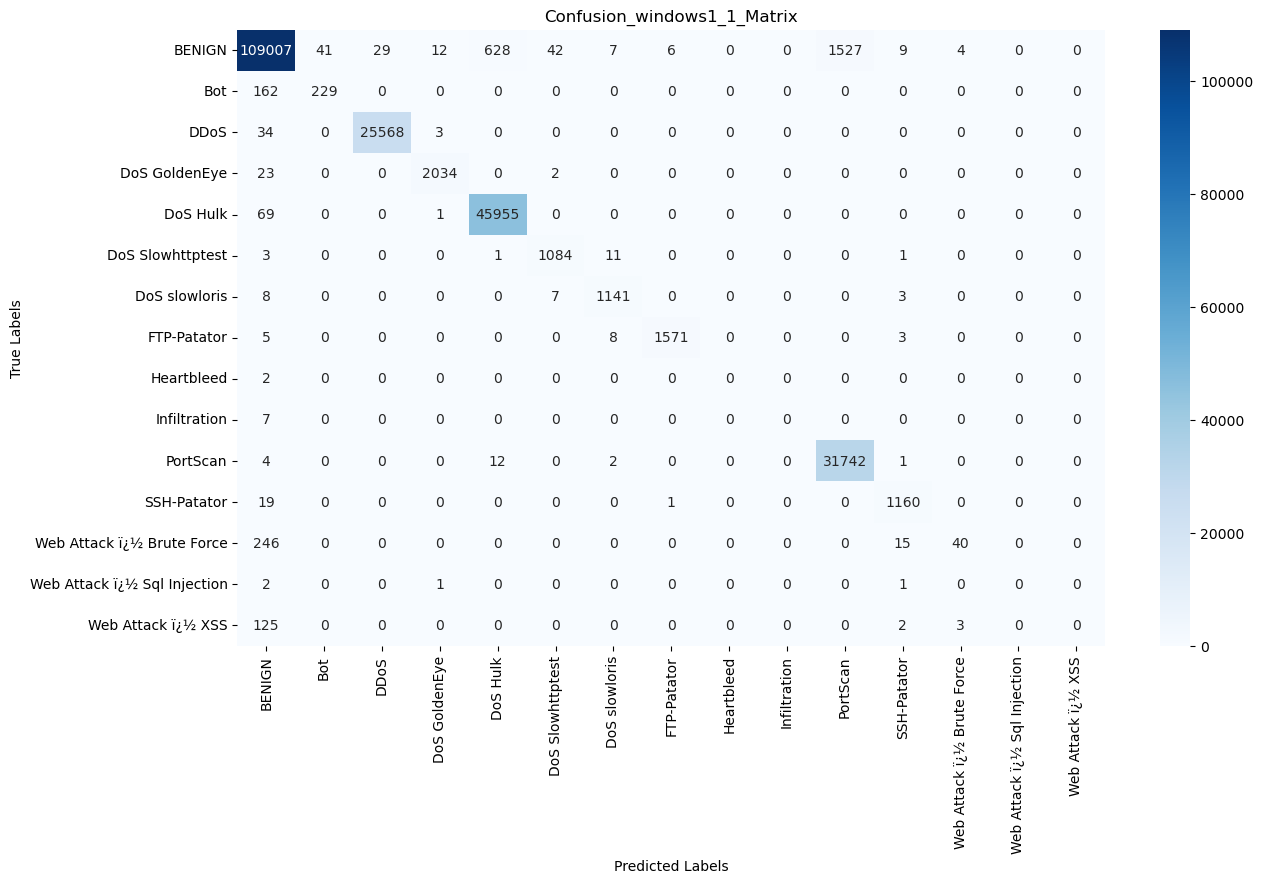

In [ ]:
# Create a list of attack types in reverse order
attack_types = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

# Create confusion matrix
confusion_matrix = confusion_matrix(y_test_pre, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(14, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion_windows"+ window_size + "_" + sliding_window + "_Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Set tick labels on the y-axis to be horizontal and in reverse order
plt.yticks(np.arange(len(attack_types)) + 0.5, attack_types, rotation=0)

# Set tick labels on the x-axis to be vertical
plt.xticks(np.arange(len(attack_types)) + 0.5, attack_types, rotation=90)

plt.savefig(PATH + "confusion_windows"+ window_size + "_" + sliding_window + "_matrix.png")
plt.show()

In [ ]:
# attack_types[1]

In [ ]:
# y_pred.dtype

## Score Calculation

In [ ]:
# print(classification_report(y_test_pre, y_pred))

In [ ]:
# Create a dataframe to store the TP, TN, FP, FN for each class
class_names = attack_types
metrics = ['True Positives', 'True Negatives', 'False Positives', 'False Negatives']
table_data = []

for i in range(0,15):
    tp = confusion_matrix[i, i]
    tn = np.sum(confusion_matrix) - (np.sum(confusion_matrix[:, i]) + np.sum(confusion_matrix[i, :]) - tp)
    fp = np.sum(confusion_matrix[:, i]) - tp
    fn = np.sum(confusion_matrix[i, :]) - tp
    total = tp + tn + fp + fn
    tp_percent = tp / total * 100
    tn_percent = tn / total * 100
    fp_percent = fp / total * 100
    fn_percent = fn / total * 100
    # table_data.append([class_names[i], tp, tn, fp, fn])
    # table_data.append([class_names[i], tp_percent, tn_percent, fp_percent, fn_percent])
    report = classification_report(y_test_pre, y_pred, output_dict=True)  # Calculate the classification report
    precision = report[str(i)]['precision']
    recall = report[str(i)]['recall']
    f1_score = report[str(i)]['f1-score']
    table_data.append([class_names[i], precision, recall, f1_score, tp_percent, tn_percent, fp_percent, fn_percent])

# Create a dataframe and print the table
df = pd.DataFrame(table_data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'True Positives', 'True Negatives', 'False Positives', 'False Negatives'])
# print(df)
df

In [ ]:
# attack_types[1]

In [ ]:
# Save the dataframe to a CSV file
df.to_csv(PATH + 'evaluation' + window_size + "_" + sliding_window + '.csv', index=False)

In [ ]:
# # Define the classes and corresponding values
# classes = ['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris',
#            'FTP-Patator', 'Heartbleed', 'Infiltration', 'PortScan', 'SSH-Patator', 'Web Attack - Brute Force',
#            'Web Attack - Sql Injection', 'Web Attack - XSS']
# true_positives = [49.931043, 0.148246, 11.50254, 0.92227, 20.672228, 0.494153, 0.516166, 0.710233, 0.000449,
#                   0.0, 14.260814, 0.526498, 0.125335, 0.0, 0.055255]
# true_negatives = [49.935086, 99.810425, 88.49746, 99.07234, 79.315193, 99.505847, 99.475299, 99.279435,
#                   99.999102, 99.995058, 85.729303, 99.462271, 99.853551, 99.997305, 99.937557]
# false_positives = [0.069181, 0.013926, 0.0, 0.002695, 0.008985, 0.0, 0.004043, 0.007637, 0.0, 0.001797,
#                    0.002695, 0.007637, 0.011231, 0.000898, 0.004043]
# false_negatives = [0.064689, 0.027403, 0.0, 0.002695, 0.003594, 0.0, 0.004492, 0.002695, 0.000449, 0.003145,
#                    0.007188, 0.003594, 0.009883, 0.001797, 0.003145]

# # Set the style of the plot
# sns.set(style="whitegrid")

# # Create four separate bar charts
# fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# # True Positives
# sns.barplot(ax=axes[0, 0], x=classes, y=true_positives)
# axes[0, 0].set_title('True Positives')
# axes[0, 0].tick_params(axis='x', rotation=90)

# # True Negatives
# sns.barplot(ax=axes[0, 1], x=classes, y=true_negatives)
# axes[0, 1].set_title('True Negatives')
# axes[0, 1].tick_params(axis='x', rotation=90)

# # False Positives
# sns.barplot(ax=axes[1, 0], x=classes, y=false_positives)
# axes[1, 0].set_title('False Positives')
# axes[1, 0].tick_params(axis='x', rotation=90)

# # False Negatives
# sns.barplot(ax=axes[1, 1], x=classes, y=false_negatives)
# axes[1, 1].set_title('False Negatives')
# axes[1, 1].tick_params(axis='x', rotation=90)

# # Adjust spacing between subplots
# plt.tight_layout()

# # Show the charts
# plt.show()


# newcode

## newcode

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import shutil
import requests, json

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.losses import BinaryCrossentropy
from keras.utils import to_categorical


from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, log_loss


botnum = 0
bot = ['https://discord.com/api/webhooks/1162767976034996274/B6CjtQF1SzNRalG_csFx8-qJ5ODBoy5SBUelbGyl-v-QhYhwdsTfE59F-K-rXj3HyUh-',
      'https://discord.com/api/webhooks/1162767979658887299/0TICfekiC9wjPmp-GqE5zrwU57q2RJHG2peel_KOYagUDYCjovYUfyNJmDR9jbD-WXoE']

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
else:
    strategy = tf.distribute.OneDeviceStrategy("GPU:0")
    print('Single device: GPU:0')

class DiscordNotificationCallback(Callback):
    def __init__(self, webhook_url, interval=1):
        super().__init__()
        self.webhook_url = webhook_url
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval == 0:
            if logs is not None:
                loss = logs.get('loss')
                accuracy = logs.get('accuracy')
                val_loss = logs.get('val_loss')
                val_accuracy = logs.get('val_accuracy')
                message = f"LSTM-CIC -> Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}"
                payload = {"content": message}
                headers = {"Content-Type": "application/json"}
                response = requests.post(self.webhook_url, data=json.dumps(payload), headers=headers)

def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created successfully.")
    else:
        print(f"Directory '{directory_path}' already exists.")

def send_discord_message(content):
    webhook_url = bot[botnum]

    data = {
        'content': content
    }

    response = requests.post(webhook_url, data=json.dumps(data), headers={'Content-Type': 'application/json'})

    if response.status_code != 204:
        raise ValueError(f'Request to discord returned an error {response.status_code}, the response is:\n{response.text}')
    
# Create input sequences using sliding windows








def create_LSTM(window_size, n_features):
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=512, activation='tanh', input_shape=(window_size, n_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=512, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=256, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=128, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=len(label_encoder.classes_), activation='sigmoid'))

    # Compile the model
    optimizer = RMSprop(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


os.chdir("C:\\Users\\Kotani Lab\\Desktop\\ML_senior_project\\ML-Based-Adaptive-Cybersecurity-Incident-Detection\\Code_and_model\\cic")

df_list = glob.glob('.\\dataset\\label_dataset\\*.csv')
# dataset = {}

model_path = '.\\lstm\\model'
csv_path = '.\\lstm\\results'
create_directory(model_path)
create_directory(csv_path)

label_encoder = LabelEncoder()


#Training and evaluation
print('Starting')
print(df_list)


df = pd.read_csv(f'.\\dataset\\label_dataset\\Bot.csv')
print('Preprocessing')
print('Label Encoder')
df['label'] = label_encoder.fit_transform(df['label'])



Single device: GPU:0
Directory '.\lstm\model' already exists.
Directory '.\lstm\results' already exists.
Starting
['.\\dataset\\label_dataset\\Bot.csv', '.\\dataset\\label_dataset\\DDoS.csv', '.\\dataset\\label_dataset\\DoS GoldenEye.csv', '.\\dataset\\label_dataset\\DoS Hulk.csv', '.\\dataset\\label_dataset\\DoS Slowhttptest.csv', '.\\dataset\\label_dataset\\DoS slowloris.csv', '.\\dataset\\label_dataset\\FTP-Patator.csv', '.\\dataset\\label_dataset\\Heartbleed.csv', '.\\dataset\\label_dataset\\Infiltration.csv', '.\\dataset\\label_dataset\\PortScan.csv', '.\\dataset\\label_dataset\\SSH-Patator.csv', '.\\dataset\\label_dataset\\Web Attack Ã\x83Â\x82Ã\x82Â\x96 Brute Force.csv', '.\\dataset\\label_dataset\\Web Attack Ã\x83Â\x82Ã\x82Â\x96 Sql Injection.csv', '.\\dataset\\label_dataset\\Web Attack Ã\x83Â\x82Ã\x82Â\x96 XSS.csv']
Preprocessing
Label Encoder


In [9]:
df.label.value_counts()

label
0    12832915
1       15355
Name: count, dtype: int64

In [4]:
# def data_generator(df, window_size, sliding_window):
#     indices = np.arange(len(df) - window_size + 1)
#     for idx in indices[::sliding_window]:
#         if idx + window_size > len(df):
#             continue
#         sequence = df.iloc[idx:idx + window_size, :-1].values
#         label = df.iloc[idx + window_size - 1, -1]
#         yield sequence, label

def data_generator(df, indices, window_size, sliding_window):
    for idx in indices:
        if idx + window_size > len(df):
            continue
        sequence = df.iloc[idx:idx + window_size, :-1].values
        label = df.iloc[idx + window_size - 1, -1]
        yield sequence, label


In [5]:

sliding_window = 1
window_size = 128
batch_size = 512

indices = np.arange(len(df) - window_size + 1)
train_indices, test_indices = train_test_split(indices, test_size=0.15, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.17647, random_state=42)        ## 70 / 30 train and val+test

print('Creating Dataset')
# Then create your tf.data.Dataset from this generator
# Training dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(df, train_indices, window_size, sliding_window),
    output_types=(tf.float32, tf.float32),
    output_shapes=((window_size, df.shape[1] - 1), ())
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Validation dataset
val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(df, val_indices, window_size, sliding_window),
    output_types=(tf.float32, tf.float32),
    output_shapes=((window_size, df.shape[1] - 1), ())
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Testing dataset
test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(df, test_indices, window_size, sliding_window),
    output_types=(tf.float32, tf.float32),
    output_shapes=((window_size, df.shape[1] - 1), ())
).batch(batch_size).prefetch(tf.data.AUTOTUNE)


Creating Dataset


In [32]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 81), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [33]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 81), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [37]:
for X_batch, y_batch in train_dataset.take(1):
    print("X_batch (features):")
    print(X_batch.numpy())
    
    print("\ny_batch (labels):")
    print(y_batch.numpy())

    print(X_batch.shape)
    print(y_batch.shape)


X_batch (features):
[[[1.0000000e+00 4.0062497e-04 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 1.0000000e+00]
  [1.0000000e+00 4.0062497e-04 0.0000000e+00 ... 0.0000000e+00
   1.0000000e+00 0.0000000e+00]
  [1.0000000e+00 2.0316665e-04 4.5504598e-06 ... 0.0000000e+00
   1.0000000e+00 0.0000000e+00]
  ...
  [3.5294119e-01 9.5849988e-05 4.5504598e-06 ... 0.0000000e+00
   1.0000000e+00 0.0000000e+00]
  [3.5294119e-01 9.5849988e-05 4.5504598e-06 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [3.5294119e-01 9.5849988e-05 4.5504598e-06 ... 0.0000000e+00
   0.0000000e+00 1.0000000e+00]]

 [[3.5294119e-01 5.3175304e-02 1.8201839e-05 ... 0.0000000e+00
   1.0000000e+00 0.0000000e+00]
  [3.5294119e-01 5.3175304e-02 1.8201839e-05 ... 0.0000000e+00
   1.0000000e+00 0.0000000e+00]
  [3.5294119e-01 1.3333332e-07 4.5504598e-06 ... 0.0000000e+00
   1.0000000e+00 0.0000000e+00]
  ...
  [1.0000000e+00 2.5965832e-04 4.5504598e-06 ... 0.0000000e+00
   0.0000000e+00 1.0000000e+00]
  [3.5294119e-01

In [38]:
for X_batch, y_batch in train_dataset.take(1):
    print("X_batch (features) - First 2 samples:")
    print(X_batch.numpy()[:2])
    print("\ny_batch (labels) - First 2 samples:")
    print(y_batch.numpy()[:2])


X_batch (features) - First 2 samples:
[[[1.0000000e+00 4.0062497e-04 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 1.0000000e+00]
  [1.0000000e+00 4.0062497e-04 0.0000000e+00 ... 0.0000000e+00
   1.0000000e+00 0.0000000e+00]
  [1.0000000e+00 2.0316665e-04 4.5504598e-06 ... 0.0000000e+00
   1.0000000e+00 0.0000000e+00]
  ...
  [3.5294119e-01 9.5849988e-05 4.5504598e-06 ... 0.0000000e+00
   1.0000000e+00 0.0000000e+00]
  [3.5294119e-01 9.5849988e-05 4.5504598e-06 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [3.5294119e-01 9.5849988e-05 4.5504598e-06 ... 0.0000000e+00
   0.0000000e+00 1.0000000e+00]]

 [[3.5294119e-01 5.3175304e-02 1.8201839e-05 ... 0.0000000e+00
   1.0000000e+00 0.0000000e+00]
  [3.5294119e-01 5.3175304e-02 1.8201839e-05 ... 0.0000000e+00
   1.0000000e+00 0.0000000e+00]
  [3.5294119e-01 1.3333332e-07 4.5504598e-06 ... 0.0000000e+00
   1.0000000e+00 0.0000000e+00]
  ...
  [1.0000000e+00 2.5965832e-04 4.5504598e-06 ... 0.0000000e+00
   0.0000000e+00 1.0000000e+00

In [6]:
for X_batch, y_batch in train_dataset.take(1):
    print("Shape of y_batch (labels):", y_batch.shape)


Shape of y_batch (labels): (512,)


In [10]:
for X_batch, y_batch in test_dataset.take(1):
    print("Shape of y_batch (labels):", y_batch.shape)


Shape of y_batch (labels): (512,)


In [11]:
for X_batch, y_batch in val_dataset.take(1):
    print("Shape of y_batch (labels):", y_batch.shape)


Shape of y_batch (labels): (512,)
